<div align="right"><b>Bronnikov Egor</b></div>

# <center>Adaptive forecasting methods</center>

## Modules

In [1]:
import pandas as pd
import numpy as np
from typing import List, Union
import warnings
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [2]:
ausair = pd.read_csv("data/ausair.csv", index_col=0)

In [3]:
ausair.head()

,Passengers
Year,
1970,7.32
1971,7.33
1972,7.80
1973,9.38
1974,10.66


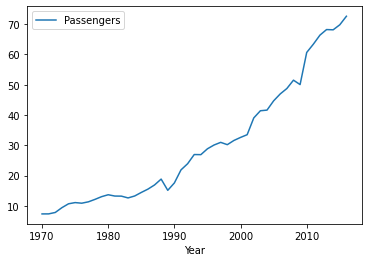

In [4]:
ausair.plot()
plt.show()

In [5]:
vals = ausair["Passengers"].values

## Brown's method

In [6]:
forecast = [vals[0]]

h = 10

alpha = 0.8

for t in range(1, vals.shape[0] + h):
    value = vals[t] if t < vals.shape[0] else forecast[-1]
    forecast.append(alpha * value + (1 - alpha) * forecast[t-1])

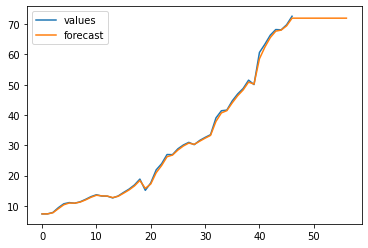

In [7]:
plt.plot(vals, label="values")
plt.plot(forecast, label="forecast")
plt.legend(loc="upper left")
plt.show()

## Holt's method

### Linear trend

In [8]:
forecast = [vals[0]]
level = vals[0]
trend = vals[1] - vals[0]
h = 10

alpha = 0.59
beta = 0.43

for t in range(1, vals.shape[0] + h):
    value = vals[t] if t < vals.shape[0] else forecast[-1]
    prev_level = level
    level = alpha * value + (1 - alpha) * (level + trend)
    trend = beta * (level - prev_level) + (1 - beta) * trend
    forecast.append(level + trend)

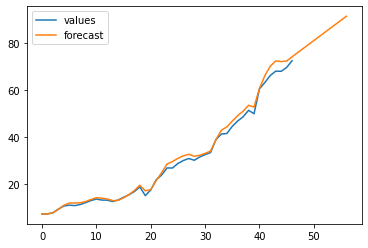

In [9]:
plt.plot(vals, label="values")
plt.plot(forecast, label="forecast")
plt.legend(loc="upper left")
plt.show()

### Additive decaying trend

In [10]:
forecast = [vals[0]]
level = vals[0]
trend = vals[1] - vals[0]

h = 10

alpha = 0.39
beta = 0.10
phi = 0.9

for t in range(1, vals.shape[0] + h):
    value = vals[t] if t < vals.shape[0] else forecast[-1]
    prev_level = level
    level = alpha * value + (1 - alpha) * (level + phi * trend)
    trend = beta * (level - prev_level) + (1 - beta) * phi * trend
    forecast.append(level + trend)

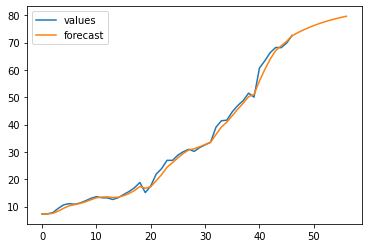

In [11]:
plt.plot(vals, label="values")
plt.plot(forecast, label="forecast")
plt.legend(loc="upper left")
plt.show()

## Holt-Winters's method

### Data

In [12]:
passengers = pd.read_csv("data/passengers.csv", index_col=0)

In [13]:
vals = passengers["num_passengers"].values

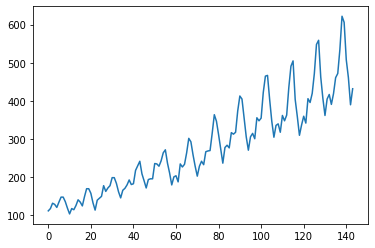

In [14]:
plt.plot(vals)
plt.show()

### Method

In [15]:
forecast = [vals[11]]
level = vals[11]
trend = np.mean(vals[12:24] - np.mean(vals[:12]))
seasonality = (vals[:12] - np.mean(vals[:12])).tolist()

h = 36
m = 12

alpha = 0.4
beta = 0.03
gamma = 0.75

for t in range(12, vals.shape[0] + h):
    value = vals[t] if t < vals.shape[0] else forecast[-1]
    prev_level, level = level, alpha * (value - seasonality[t-m]) + (1 - alpha) * (level + trend)
    prev_trend, trend = trend, beta * (level - prev_level) + (1 - beta) * trend
    seasonality.append(gamma * (value - prev_level - prev_trend) + (1 - gamma) * seasonality[t-m])
    forecast.append(level + trend + seasonality[t-m+1])

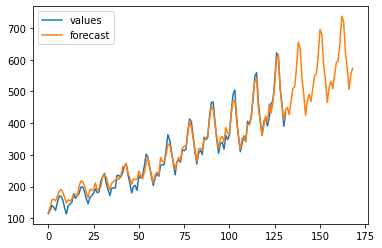

In [16]:
plt.plot(vals[12:], label="values")
plt.plot(forecast, label="forecast")
plt.legend(loc="upper left")
plt.show()

### Function

In [17]:
def holt_winters(series: List[Union[int, float]],
                 h=0, m=12, alpha=0.4, beta=0.03, gamma=0.75, phi=1, *,
                 mode="additive") -> Union[List[Union[int, float]], None]:
    """ Function that makes forecast by the Holt-Winters method
    
        :param series: series of raw values
        :type series: List[Union[int, float]]
        :param h: number of units for which we make the forecast
        :type h: int
        :param m: seasonality length
        :type m: int
        :param alpha: parameter that describes the dependence on the current value of the series (lies between 0 and 1)
        :type alpha: float
        :param beta: parameter that describes the dependence on the current value of the series (lies between 0 and 1)
        :type beta: float
        :param beta: parameter which is used in the trend component (lies between 0 and 1)
        :type beta: float
        :param gamma: parameter which is responsible for seasonality
        :type gamma: float
        :param phi: damping coefficient (lies between 0 and 1)
        :type phi: float
        
        :param mode: type of seasonality - additive or multiplicative
        :type mode: str
        
        :return: if you select the correct `mode`, it gives the forecast, otherwise it gives `None`
        :rtype: Union[List[Union[int, float]], None]
    """
    forecast = [series[m-1]]
    level = series[m-1]

    if mode == "additive":
        trend = np.mean(series[m:2*m] - np.mean(series[:m]))
        seasonality = (series[:m] - np.mean(series[:m])).tolist()
        for t in range(12, vals.shape[0] + h):
            value = series[t] if t < series.shape[0] else forecast[-1]
            prev_level, level = level, alpha * (value - seasonality[t-m]) + (1 - alpha) * (level + phi * trend)
            prev_trend, trend = trend, beta * (level - prev_level) + (1 - beta) * phi * trend
            seasonality.append(gamma * (value - prev_level - prev_trend) + (1 - gamma) * seasonality[t-m])
            forecast.append(level + trend + seasonality[t-m+1])
        return forecast
    elif mode == "multiplicative":
        trend = np.mean(series[m:2*m] / np.mean(series[:m]))
        seasonality = (series[:m] / np.mean(series[:m])).tolist()
        for t in range(12, vals.shape[0] + h):
            value = series[t] if t < series.shape[0] else forecast[-1]
            prev_level, level = level, alpha * (value/seasonality[t-m]) + (1 - alpha) * (level * trend**phi)
            prev_trend, trend = trend, beta * (level / prev_level) + (1 - beta) * trend**phi
            seasonality.append(gamma * (value/(prev_level + prev_trend)) + (1 - gamma) * seasonality[t-m])
            forecast.append(level * trend**phi * seasonality[t-m+1])
        return forecast
    else:
        warnings.warn("Error: Wrong `mode` parameter is selected...", category=UserWarning)
        return None

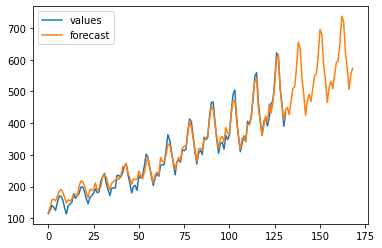

In [18]:
plt.plot(vals[12:], label="values")
plt.plot(holt_winters(vals, 36), label="forecast")
plt.legend(loc="upper left")
plt.show()

In [ ]:
plt.plot(vals[12:], label="values")
plt.plot(holt_winters(vals, h=36, mode="multiplicative"), label="forecast")
plt.legend(loc="upper left")
plt.show()

In [ ]:
holt_winters(vals, h=36, mode="errr")

<div class="alert alert-success" style="text-align: center;">
    <h2>Homework</h2>
</div>

### Optimizing parameters

In [ ]:
def mean_squared_error(series: List[Union[int, float]],
                       m=12, alpha=0.4, beta=0.03, gamma=0.75, phi=1, *,
                       mode="additive"):
    forecast = holt_winters(series, 0, m, alpha, beta, gamma, phi, mode=mode)
    return (np.sum((series[m:]-forecast[:-1])**2))/len(series[m:])

In [ ]:
mean_squared_error(vals)

#### Additive seasonality

In [ ]:
h = 36
m = 12
phi = 1

func = lambda x: mean_squared_error(vals, m, x[0], x[1], x[2], phi, mode="additive")
bnds = ((0,None) for _ in range(3))
optimization = minimize(func, (0,0,0), bounds=bnds)

print(optimization)
alpha_a, beta_a, gamma_a = tuple(optimization["x"])

In [ ]:
plt.plot(vals[12:], label="values")
plt.plot(holt_winters(vals, h=36, alpha=alpha_a, beta=beta_a, gamma=gamma_a, phi=phi), label="forecast")
plt.legend(loc="upper left")
plt.show()

#### Multiplicative seasonality

In [ ]:
h = 36
m = 12
phi = 1

func = lambda x: mean_squared_error(vals, m, x[0], x[1], x[2], phi, mode="multiplicative")
bnds = ((0,None) for _ in range(3))
optimization = minimize(func, (0.5,0.5,0.5), bounds=bnds)

print(optimization)
alpha_m, beta_m, gamma_m = tuple(optimization["x"])

In [ ]:
plt.plot(vals[12:], label="values")
plt.plot(holt_winters(vals, h=h, alpha=alpha_m, beta=beta_m, gamma=gamma_m, phi=phi, mode="multiplicative"), label="forecast")
plt.legend(loc="upper left")
plt.show()

#### Comparison of approximations and obtained values

In [ ]:
plt.plot(vals[12:], label="values")
plt.plot(holt_winters(vals, h=h, alpha=alpha_a, beta=beta_a, gamma=gamma_a, phi=phi, mode="additive"), label="additive")
plt.plot(holt_winters(vals, h=h, alpha=alpha_m, beta=beta_m, gamma=gamma_m, phi=phi, mode="multiplicative"), label="multiplicative")
plt.legend(loc="upper left")
plt.show()